In [32]:
pip install tensorflow-text==2.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 101 kB 15.2 MB/s 
     |████████████████████████████████| 596 kB 72.5 MB/s 
     |████████████████████████████████| 6.6 MB 68.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
# import string
import nltk
# from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Input,Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os
import keras
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import ModelCheckpoint
import datetime
from keras.layers import Dropout,SpatialDropout1D
from keras.regularizers import l2
from keras.layers import concatenate, BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from datetime import time
# from keras.callbacks import TensorBoard, ModelCheckpoint
from nltk.stem import WordNetLemmatizer
from keras.preprocessing import sequence
from keras.layers import LeakyReLU

import tensorflow_hub as hub
import tensorflow_text as text
from transformers import DistilBertTokenizer,TFDistilBertModel, RobertaTokenizer, TFRobertaModel

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from prettytable import PrettyTable

In [34]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

###  Importing the data

In [35]:
# train_df=pd.read_csv('../input/nlp-getting-started/train.csv')
# test_df=pd.read_csv('../input/nlp-getting-started/test.csv')

In [36]:
# importing the data

train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

In [37]:
train_df=train_df[['text', 'target']]
test_df=test_df[['text']]

In [38]:
train_df=train_df.sample(frac=1) # shuffling the dataframe
train_df.head()

,text,target
1113,@ChristophersZen @HunterLove1995 @tblack yeah ...,0
521,2 TIX 10/3 Frozen Fury XVII: Los Angeles Kings...,0
4364,Remove the http://t.co/JAb541hHk0 and Linkury ...,1
6516,In a dream you saw a way to survive and you we...,0
6025,'Seismic' Apple TV service to stream 25 channe...,0


# 1) Basic Preprocessing

In [39]:
# 1 Converting to lower-case
def lowercase(text):
    return text.lower()

# 2 Decontracting the text
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'cause", " because", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)
    return phrase

# 3 Removing URLs
def remove_url(text):
    text= re.sub(r'https?://\S+|www\.\S+', '', text)
    return text

# 4 Removing HTMLs
def remove_html(text):
    text=re.sub(r'<.*?>','',text)
    return text


In [40]:
# 5 Removing Slangs or chat words
# Converting slangs and chat words like BRB to Be Right Back, FYI to For Your Information
slangs="""AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
QPSA=Que Pasa?
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
IG=Instagram
FB=Facebook
PPL=People
R=Are
PC=Computer"""

# Making the dictionary of the above strings
pattern=re.compile('\\n')
slangs=pattern.sub(r'  ',slangs)
slangs_dict={}
for i in slangs.split('  '):
    lst=i.split('=')
    slangs_dict[lst[0]]=lst[1]

def remove_slangs(text):
    new_text=[]
    for word in text.split():
        if word.upper() in slangs_dict:
            new_text.append(slangs_dict[word.upper()].lower())
        else:
            new_text.append(word)
    return ' '.join(new_text)


In [41]:
def basic_preprocessing(text):
    
    text=lowercase(text)           # 1
    text=decontracted(text)        # 2    
    text=remove_url(text)          # 3
    text=remove_html(text)         # 4
    text=remove_slangs(text)       # 5
    
    return text

In [42]:
# preprocessing train data
train_df_preprocessed=train_df.copy()
train_df_preprocessed['text']=train_df['text'].apply(basic_preprocessing)

# preprocessing test data
X_test_preprocessed=test_df.copy()
X_test_preprocessed['text']=X_test_preprocessed['text'].apply(basic_preprocessing)

In [43]:
train_df_preprocessed['text'].head()

1113    @christopherszen @hunterlove1995 @tblack yeah ...
521     2 tix 10/3 frozen fury xvii: los angeles kings...
4364              remove the and linkury browser hijacker
6516    in a dream you saw a way to survive and you we...
6025    iseismic' apple tv service to stream 25 channe...
Name: text, dtype: object

###  Splitting the data

In [44]:
X=train_df_preprocessed['text']
y=train_df_preprocessed['target']

# Splitting the train data into train and cv

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
X_test=X_test_preprocessed['text']
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

(6090,) (6090,)
(1523,) (1523,)
(3263,)


In [45]:
def performance_evaluation(model,X_test,y_test):
    
    """This function prints the confusion matrix and all the other evalutaion metrics like Precision, Recall and F1 Score"""
    
    # Predicted probabilities
    y_pred_proba=model.predict(X_test)
    
    # Converting to Binary Values (Threshold=0.5)
    y_pred=np.where(y_pred_proba>0.5, 1, 0)

    
    # Plotting Confusion Matrix
    c_test=confusion_matrix(y_test,y_pred)

    plt.figure(figsize=(6,6))
    sns.heatmap(c_test/np.sum(c_test),annot=True,fmt='.2%',cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix")
    plt.show()
    

    tn,fp,fn,tp=c_test.ravel()
    # print(classification_report(y_test,y_test_pred_value))
    print()
    
    table=PrettyTable(['Metrics','Values'])
    table.add_row(['Specificity(%)',np.round((tn/(tn+fp))*100,2)])
    table.add_row(['Sensitivity/Recall(%)',np.round((tp/(tp+fn))*100,2)])
    table.add_row(['Precision(%)',np.round((tp/(tp+fp))*100,2)])
    table.add_row(['Micro F1 Score',np.round(f1_score(y_test,y_pred,average='micro'),2)])
    model_metrics=[np.round((tn/(tn+fp))*100,2),np.round((tp/(tp+fn))*100,2),np.round((tp/(tp+fp))*100,2),np.round(f1_score(y_test,y_pred,average='micro'),2)]
    print(table)

    return model_metrics
   

# 2) Modelling

## 1) BERT-Base( 12 layers, 768 hidden size, 12 self-attention heads, 110M parameters)

In [17]:
## ref - https://tfhub.dev/google/collections/bert/1
## ref - https://www.tensorflow.org/text/tutorials/classify_text_with_bert
## ref - https://www.youtube.com/watch?v=hOCDJyZ6quA

preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

bert_preprocess=hub.KerasLayer(preprocess_url)
bert_encoder=hub.KerasLayer(encoder_url)

In [18]:
## Model Architecture


# BERT Layers
input_text=Input(shape=(), dtype=tf.string, name='text')
preprocessed_text=bert_preprocess(input_text)
outputs= bert_encoder(preprocessed_text)

# NN layers
l1= Dropout(0.1, name='dropout')(outputs['pooled_output']) # Pooled output is the output of the last encoder which is 12th encoder
l2=Dense(1, activation='sigmoid', name='output')(l1)

# Functional Model
model_bert_base=Model(inputs=[input_text], outputs=[l2])

In [19]:
model_bert_base.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'sequence_output':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [20]:
Metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
#          tf.keras.metrics.Precision(name='precision'),
#         tf.keras.metrics.Recall(name='recall')]

model_bert_base.compile(optimizer='adam', loss='binary_crossentropy', metrics=Metrics)

In [21]:
## Training the model 
Epochs = 30
model_bert_base_results= model_bert_base.fit(X_train, y_train, batch_size=128 ,epochs = Epochs, validation_data=(X_val, y_val))

Epoch 1/30
48/48 [==============================] - 108s 2s/step - loss: 0.6729 - accuracy: 0.5880 - val_loss: 0.6210 - val_accuracy: 0.6566
Epoch 2/30
48/48 [==============================] - 96s 2s/step - loss: 0.6217 - accuracy: 0.6534 - val_loss: 0.5950 - val_accuracy: 0.7045
Epoch 3/30
48/48 [==============================] - 97s 2s/step - loss: 0.5996 - accuracy: 0.6811 - val_loss: 0.5801 - val_accuracy: 0.7190
Epoch 4/30
48/48 [==============================] - 97s 2s/step - loss: 0.5934 - accuracy: 0.6892 - val_loss: 0.5704 - val_accuracy: 0.7367
Epoch 5/30
48/48 [==============================] - 97s 2s/step - loss: 0.5777 - accuracy: 0.7057 - val_loss: 0.5710 - val_accuracy: 0.7098
Epoch 6/30
48/48 [==============================] - 97s 2s/step - loss: 0.5731 - accuracy: 0.7136 - val_loss: 0.5570 - val_accuracy: 0.7387
Epoch 7/30
48/48 [==============================] - 97s 2s/step - loss: 0.5675 - accuracy: 0.7164 - val_loss: 0.5555 - val_accuracy: 0.7341
Epoch 8/30
48/48 [=

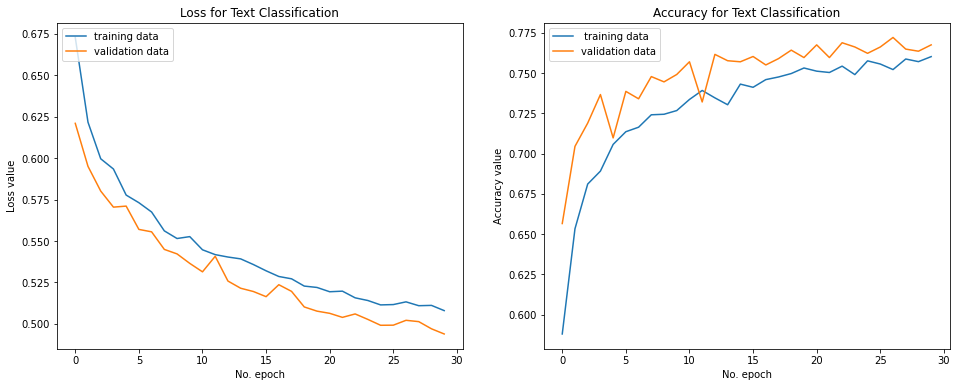

In [22]:
plt.figure(figsize=(16,6))

## Loss vs Epochs for train and validation data
plt.subplot(1,2,1)
plt.plot(model_bert_base_results.history['loss'], label='training data')
plt.plot(model_bert_base_results.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

## Accuracy vs Epochs for train and validation data
plt.subplot(1,2,2)
plt.plot(model_bert_base_results.history['accuracy'], label=' training data')
plt.plot(model_bert_base_results.history['val_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

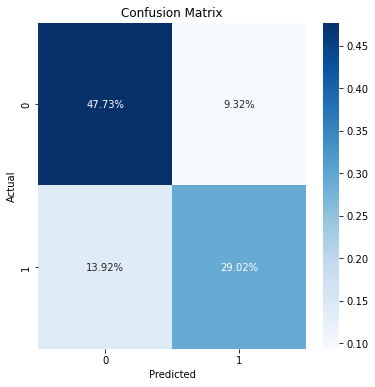


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 83.66  |
| Sensitivity/Recall(%) | 67.58  |
|      Precision(%)     | 75.68  |
|     Micro F1 Score    |  0.77  |
+-----------------------+--------+


In [23]:
model_bert_base_metrices=performance_evaluation(model_bert_base, X_val,y_val)

## 2) DistilBERT (40% less parameters, 60% faster than BERT-Base)

In [46]:
# Loading BERT tokenizer and Model

dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [47]:
def text_encoding(tokenizer, texts, max_length, batch_size=256):
    
    """This function return the text embeddings after tokenization and padding the text."""
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_len, padding='longest',
                                             truncation=True, return_attention_mask=True,
                                             return_token_type_ids=False)
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [48]:
max_len = 32
X_train_ids, X_train_attention = text_encoding(dbert_tokenizer, X_train.tolist(),max_len)
X_val_ids, X_val_attention = text_encoding(dbert_tokenizer, X_val.tolist(), max_len)
X_test_ids, X_test_attention = text_encoding(dbert_tokenizer, X_test.tolist(), max_len)

In [49]:
# Making the layers untrainable
for layer in dbert_model.layers:
    layer.trainable = False

In [50]:
# Model architecture

weight_initializer = tf.keras.initializers.GlorotNormal(seed=42)

# DistilBERT Layers
input_ids_layer = Input(shape=(max_len,), name='input_ids', dtype='int32')
input_attention_layer = Input(shape=(max_len,), name='input_attention', dtype='int32')
last_hidden_state = dbert_model([input_ids_layer, input_attention_layer])[0]
cls_token = last_hidden_state[:, 0, :]

# NN layer
output = Dense(1,activation='sigmoid',kernel_initializer=weight_initializer)(cls_token)

model_dbert = Model(inputs=[input_ids_layer, input_attention_layer], outputs=output)

In [51]:
model_dbert.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 768)          0           tf_distil_bert_model_1[0][0

In [52]:
model_dbert.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [53]:
Epochs=30
Batch_size=128

model_dbert_results = model_dbert.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train,
    epochs = Epochs,
    batch_size = Batch_size,
    validation_data = ([X_val_ids, X_val_attention], y_val))



Epoch 1/30
48/48 [==============================] - 15s 198ms/step - loss: 0.5992 - accuracy: 0.7003 - val_loss: 0.5258 - val_accuracy: 0.7676
Epoch 2/30
48/48 [==============================] - 8s 173ms/step - loss: 0.5203 - accuracy: 0.7603 - val_loss: 0.4826 - val_accuracy: 0.7853
Epoch 3/30
48/48 [==============================] - 9s 178ms/step - loss: 0.4881 - accuracy: 0.7741 - val_loss: 0.4601 - val_accuracy: 0.7932
Epoch 4/30
48/48 [==============================] - 8s 175ms/step - loss: 0.4723 - accuracy: 0.7823 - val_loss: 0.4480 - val_accuracy: 0.8024
Epoch 5/30
48/48 [==============================] - 8s 173ms/step - loss: 0.4597 - accuracy: 0.7910 - val_loss: 0.4395 - val_accuracy: 0.8102
Epoch 6/30
48/48 [==============================] - 8s 171ms/step - loss: 0.4552 - accuracy: 0.7933 - val_loss: 0.4351 - val_accuracy: 0.8109
Epoch 7/30
48/48 [==============================] - 8s 169ms/step - loss: 0.4463 - accuracy: 0.8000 - val_loss: 0.4319 - val_accuracy: 0.8116
Epoch

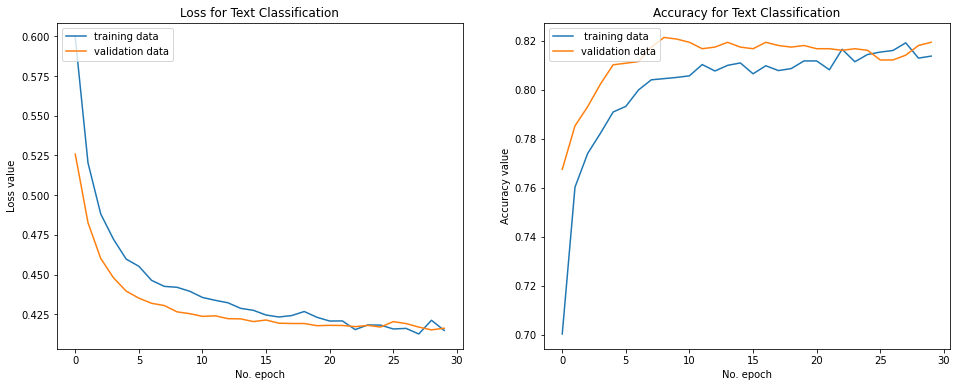

In [54]:
plt.figure(figsize=(16,6))

## Loss vs Epochs for train and validation data
plt.subplot(1,2,1)
plt.plot(model_dbert_results.history['loss'], label='training data')
plt.plot(model_dbert_results.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

## Accuracy vs Epochs for train and validation data
plt.subplot(1,2,2)
plt.plot(model_dbert_results.history['accuracy'], label=' training data')
plt.plot(model_dbert_results.history['val_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

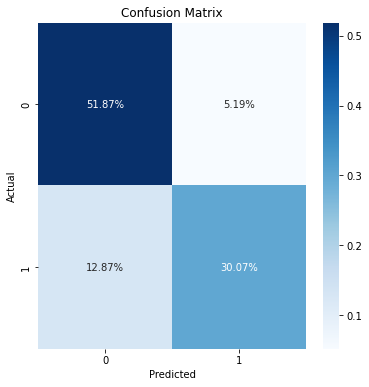


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 90.91  |
| Sensitivity/Recall(%) | 70.03  |
|      Precision(%)     | 85.29  |
|     Micro F1 Score    |  0.82  |
+-----------------------+--------+


In [55]:
model_dbert_metrices=performance_evaluation(model_dbert, [X_val_ids, X_val_attention], y_val)

## 3) RoBERTa

In [56]:
# Loading BERT tokenizer and Model

roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [57]:
def text_encoding(tokenizer, texts, max_length, batch_size=256):
    
    """This function return the text embeddings after tokenization and padding the text."""
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_len, padding='longest',
                                             truncation=True, return_attention_mask=True,
                                             return_token_type_ids=False)
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [58]:
max_len = 32
X_train_ids, X_train_attention = text_encoding(roberta_tokenizer, X_train.tolist(),max_len)
X_val_ids, X_val_attention = text_encoding(roberta_tokenizer, X_val.tolist(), max_len)
X_test_ids, X_test_attention = text_encoding(roberta_tokenizer, X_test.tolist(), max_len)

In [59]:
# Making the layers untrainable
for layer in roberta_model.layers:
    layer.trainable = False

In [60]:
# Model architecture

weight_initializer = tf.keras.initializers.GlorotNormal(seed=42)

# DistilBERT Layers
input_ids_layer = Input(shape=(max_len,), name='input_ids', dtype='int32')
input_attention_layer = Input(shape=(max_len,), name='input_attention', dtype='int32')
last_hidden_state = roberta_model([input_ids_layer, input_attention_layer])[0]
cls_token = last_hidden_state[:, 0, :]

# NN layer
output = Dense(1,activation='sigmoid',kernel_initializer=weight_initializer)(cls_token)

model_roberta = Model(inputs=[input_ids_layer, input_attention_layer], outputs=output)

In [61]:
model_roberta.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 768)          0           tf_roberta_model[0][0]     

In [62]:
model_roberta.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [63]:
Epochs=30
Batch_size=128

model_roberta_results = model_roberta.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train,
    epochs = Epochs,
    batch_size = Batch_size,
    validation_data = ([X_val_ids, X_val_attention], y_val))


Epoch 1/30
48/48 [==============================] - 30s 391ms/step - loss: 0.6784 - accuracy: 0.5709 - val_loss: 0.6702 - val_accuracy: 0.5706
Epoch 2/30
48/48 [==============================] - 16s 341ms/step - loss: 0.6623 - accuracy: 0.5791 - val_loss: 0.6562 - val_accuracy: 0.5726
Epoch 3/30
48/48 [==============================] - 16s 335ms/step - loss: 0.6466 - accuracy: 0.6023 - val_loss: 0.6429 - val_accuracy: 0.5955
Epoch 4/30
48/48 [==============================] - 16s 332ms/step - loss: 0.6360 - accuracy: 0.6401 - val_loss: 0.6317 - val_accuracy: 0.6664
Epoch 5/30
48/48 [==============================] - 16s 331ms/step - loss: 0.6212 - accuracy: 0.6862 - val_loss: 0.6207 - val_accuracy: 0.7052
Epoch 6/30
48/48 [==============================] - 16s 334ms/step - loss: 0.6141 - accuracy: 0.7102 - val_loss: 0.6106 - val_accuracy: 0.7190
Epoch 7/30
48/48 [==============================] - 16s 336ms/step - loss: 0.6044 - accuracy: 0.7250 - val_loss: 0.6022 - val_accuracy: 0.7275

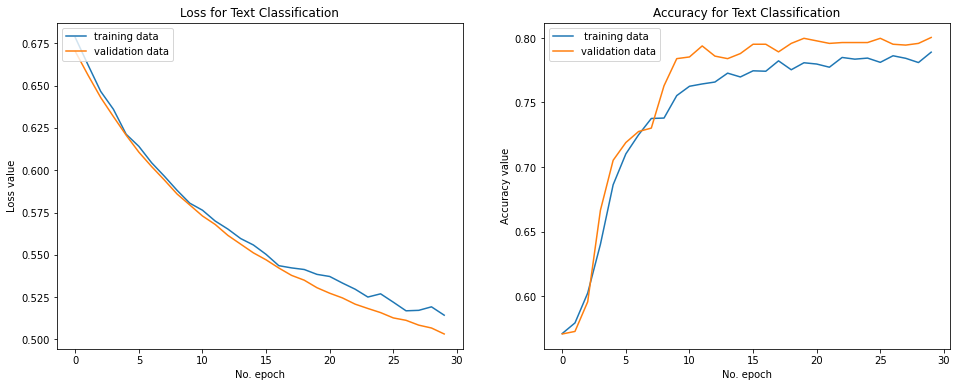

In [64]:
plt.figure(figsize=(16,6))

## Loss vs Epochs for train and validation data
plt.subplot(1,2,1)
plt.plot(model_roberta_results.history['loss'], label='training data')
plt.plot(model_roberta_results.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

## Accuracy vs Epochs for train and validation data
plt.subplot(1,2,2)
plt.plot(model_roberta_results.history['accuracy'], label=' training data')
plt.plot(model_roberta_results.history['val_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

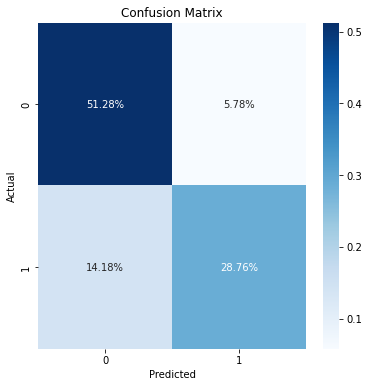


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 89.87  |
| Sensitivity/Recall(%) | 66.97  |
|      Precision(%)     | 83.27  |
|     Micro F1 Score    |  0.8   |
+-----------------------+--------+


In [65]:
model_roberta_metrices=performance_evaluation(model_roberta, [X_val_ids, X_val_attention], y_val)

## Conclusions 
- We trained 3 Bert models- Bert Base, DistilBERT and ROFL
- Our metric is F1 Score
- Best F1 Score is given by DistilBERT
- Overall AUC scores are also highest for DistilBERT